In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tensorflow

In [ ]:
# Utilities and OS interaction
import os
from os import listdir
import glob
import random

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import plotly.express as px

# Image processing
import cv2
from PIL import Image

# Machine learning and deep learning frameworks
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# PyTorch and related libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Pretrained models and utilities
import timm
from tqdm import tqdm

# Set seed for reproducibility
random.seed(100)

dataset_path = '/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset'

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


**Paths**

In [ ]:
dicom_data = pd.read_csv('/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/csv/dicom_info.csv')
image_dir = '/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/jpeg'
calc_case_train_df = pd.read_csv('/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/csv/calc_case_description_train_set.csv')
calc_case_test_df = pd.read_csv('/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/csv/calc_case_description_test_set.csv')
mass_case_train_df = pd.read_csv('/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/csv/mass_case_description_train_set.csv')
mass_case_test_df = pd.read_csv('/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/csv/mass_case_description_test_set.csv')

In [ ]:
dicom_data['SeriesDescription'].unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

In [ ]:
dicom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

**DataFrames**

In [ ]:
#Filtering dataset based on Series Description to extract specific types of images
cropped_images=dicom_data[dicom_data.SeriesDescription=='cropped images'].image_path
full_mammo_images=dicom_data[dicom_data.SeriesDescription=='full mammogram images'].image_path
ROI_mask_images=dicom_data[dicom_data.SeriesDescription=='ROI mask images'].image_path

In [ ]:
cropped_images=cropped_images.replace('CBIS-DDSM/jpeg',image_dir, regex=True)
full_mammo_images=full_mammo_images.replace('CBIS-DDSM/jpeg',image_dir,regex=True)
ROI_mask_images=ROI_mask_images.replace('CBIS-DDSM/jpeg',image_dir,regex=True)

In [ ]:
print('Cropped Images paths:\n')
print(cropped_images.iloc[0])
print('Full mammo Images paths:\n')
print(full_mammo_images.iloc[0])
print('ROI Mask Images paths:\n')
print(ROI_mask_images.iloc[0])

Cropped Images paths:

/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg
Full mammo Images paths:

/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg
ROI Mask Images paths:

/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [ ]:
#Creating dictionaries where the keys are derived from the paths of the di_data images, where the path is split be /.

full_mammo_images_dict=dict()
cropped_images_dict=dict()
ROI_mask_images_dict=dict()

for data1 in full_mammo_images:
    key=data1.split("/")[7]
    full_mammo_images_dict[key]=data1
for data1 in cropped_images:
    key=data1.split("/")[7]
    cropped_images_dict[key]=data1
for data1 in ROI_mask_images:
    key=data1.split("/")[7]
    ROI_mask_images_dict[key]=data1

# view keys
next(iter((full_mammo_images_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [ ]:
cal_test_data=pd.read_csv('/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/csv/calc_case_description_test_set.csv')
cal_test_data.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00038,2,LEFT,CC,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00038,2,LEFT,MLO,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00038,2,RIGHT,CC,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....
3,P_00038,2,RIGHT,CC,2,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....
4,P_00038,2,RIGHT,MLO,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...


In [ ]:
cal_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326 entries, 0 to 325
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               326 non-null    object
 1   breast density           326 non-null    int64 
 2   left or right breast     326 non-null    object
 3   image view               326 non-null    object
 4   abnormality id           326 non-null    int64 
 5   abnormality type         326 non-null    object
 6   calc type                322 non-null    object
 7   calc distribution        263 non-null    object
 8   assessment               326 non-null    int64 
 9   pathology                326 non-null    object
 10  subtlety                 326 non-null    int64 
 11  image file path          326 non-null    object
 12  cropped image file path  326 non-null    object
 13  ROI mask file path       326 non-null    object
dtypes: int64(4), object(10)
memory usage: 35.8

In [ ]:
mass_test_data=pd.read_csv('/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/csv/mass_case_description_test_set.csv')
mass_test_data.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [ ]:
mass_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378 entries, 0 to 377
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               378 non-null    object
 1   breast_density           378 non-null    int64 
 2   left or right breast     378 non-null    object
 3   image view               378 non-null    object
 4   abnormality id           378 non-null    int64 
 5   abnormality type         378 non-null    object
 6   mass shape               378 non-null    object
 7   mass margins             361 non-null    object
 8   assessment               378 non-null    int64 
 9   pathology                378 non-null    object
 10  subtlety                 378 non-null    int64 
 11  image file path          378 non-null    object
 12  cropped image file path  378 non-null    object
 13  ROI mask file path       378 non-null    object
dtypes: int64(4), object(10)
memory usage: 41.5

In [ ]:
mass_test_data.isna().sum()

,0
patient_id,0
breast_density,0
left or right breast,0
image view,0
abnormality id,0
abnormality type,0
mass shape,0
mass margins,17
assessment,0
pathology,0


In [ ]:
print(mass_test_data.shape)

(378, 14)


In [ ]:
cal_train_data=pd.read_csv('/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/csv/calc_case_description_train_set.csv')
cal_train_data.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [ ]:
cal_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1546 entries, 0 to 1545
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1546 non-null   object
 1   breast density           1546 non-null   int64 
 2   left or right breast     1546 non-null   object
 3   image view               1546 non-null   object
 4   abnormality id           1546 non-null   int64 
 5   abnormality type         1546 non-null   object
 6   calc type                1526 non-null   object
 7   calc distribution        1170 non-null   object
 8   assessment               1546 non-null   int64 
 9   pathology                1546 non-null   object
 10  subtlety                 1546 non-null   int64 
 11  image file path          1546 non-null   object
 12  cropped image file path  1546 non-null   object
 13  ROI mask file path       1546 non-null   object
dtypes: int64(4), object(10)
memory usage: 16

In [ ]:
mass_train_data=pd.read_csv('/content/drive/MyDrive/Breast_Cancer_Detection_For_FYP/cbis-ddsm-dataset/csv/mass_case_description_train_set.csv')
mass_train_data.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [ ]:
mass_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318 entries, 0 to 1317
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               1318 non-null   object
 1   breast_density           1318 non-null   int64 
 2   left or right breast     1318 non-null   object
 3   image view               1318 non-null   object
 4   abnormality id           1318 non-null   int64 
 5   abnormality type         1318 non-null   object
 6   mass shape               1314 non-null   object
 7   mass margins             1275 non-null   object
 8   assessment               1318 non-null   int64 
 9   pathology                1318 non-null   object
 10  subtlety                 1318 non-null   int64 
 11  image file path          1318 non-null   object
 12  cropped image file path  1318 non-null   object
 13  ROI mask file path       1318 non-null   object
dtypes: int64(4), object(10)
memory usage: 14

In [ ]:
mass_train_data.isna().sum()

,0
patient_id,0
breast_density,0
left or right breast,0
image view,0
abnormality id,0
abnormality type,0
mass shape,4
mass margins,43
assessment,0
pathology,0


In [ ]:
print(mass_train_data.shape)

(1318, 14)


In [ ]:
mass_train_data.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [ ]:
#Update specific columns in a dataset based on mappings stored in previously defined dictionaries

def fix_image_path(data):
    for i, img in enumerate(data.values):
        img_name=img[11].split("/")[2]
        data.iloc[i,11]=full_mammo_images_dict[img_name]

        img_name=img[12].split("/")[2]
        data.iloc[i,12]=cropped_images_dict[img_name]

        img_name=img[13].split("/")[2]
        data.iloc[i,13]=ROI_mask_images_dict[img_name]

In [ ]:
#Applying the function defined above to update the images in the mass datasets
fix_image_path(mass_test_data)
fix_image_path(mass_train_data)

In [ ]:
mass_train_data

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,P_02033,2,RIGHT,MLO,1,mass,IRREGULAR,ILL_DEFINED,3,MALIGNANT,4,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...
1314,P_02079,2,RIGHT,CC,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...
1315,P_02079,2,RIGHT,MLO,1,mass,ROUND,SPICULATED,3,MALIGNANT,5,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...
1316,P_02092,2,LEFT,CC,1,mass,IRREGULAR,SPICULATED,3,MALIGNANT,2,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...,/content/drive/MyDrive/Breast_Cancer_Detection...


In [ ]:
mass_test=mass_test_data.rename(columns={'left or right breast':'left_or_right_breast',
'image view':'image_view','abnormality id':'abnormality_id','mass shape':'mass_shape',
'mass margins':'mass_margins','image file path':'image_file_path',
'cropped image file path':'cropped_image_file_path',
'ROI mask file path':'ROI_mask_file_path'})

mass_train=mass_train_data.rename(columns={'left or right breast':'left_or_right_breast',
'image view':'image_view','abnormality id':'abnormality_id','mass shape':'mass_shape',
'mass margins':'mass_margins','image file path':'image_file_path',
'cropped image file path':'cropped_image_file_path',
'ROI mask file path':'ROI_mask_file_path'})

In [ ]:
# fill in missing values using the backwards fill method
mass_train['mass_shape'] = mass_train['mass_shape'].bfill()
mass_train['mass_margins'] = mass_train['mass_margins'].bfill()

#check null values
mass_train.isnull().sum()

,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality_id,0
abnormality type,0
mass_shape,0
mass_margins,0
assessment,0
pathology,0


In [ ]:
# check datasets shape
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [ ]:
# Display some images
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# create function to display images
def display_images(column, number):
    """displays images in dataset"""
    # create figure and axes
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))

    # Loop through rows and display images
    for index, row in mass_train.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = mpimg.imread(image_path)
        ax = axes[index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Full Mammograms:



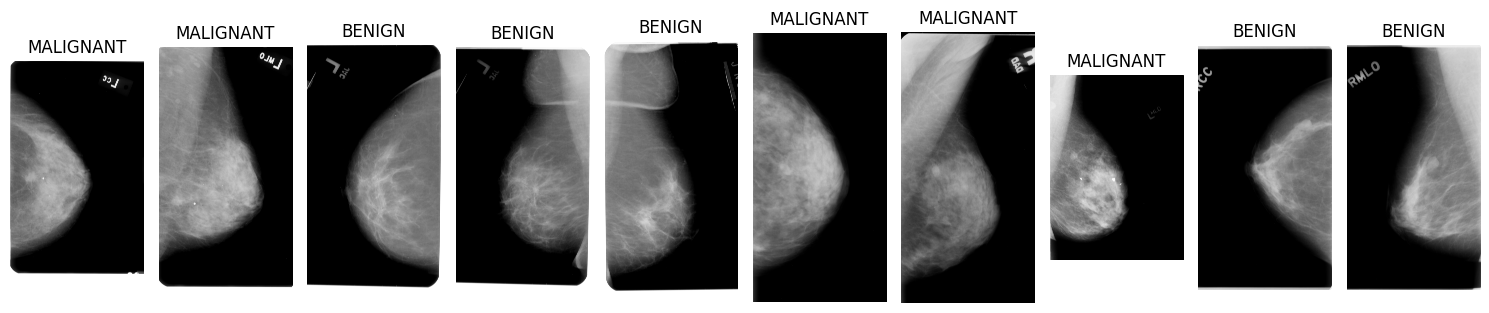

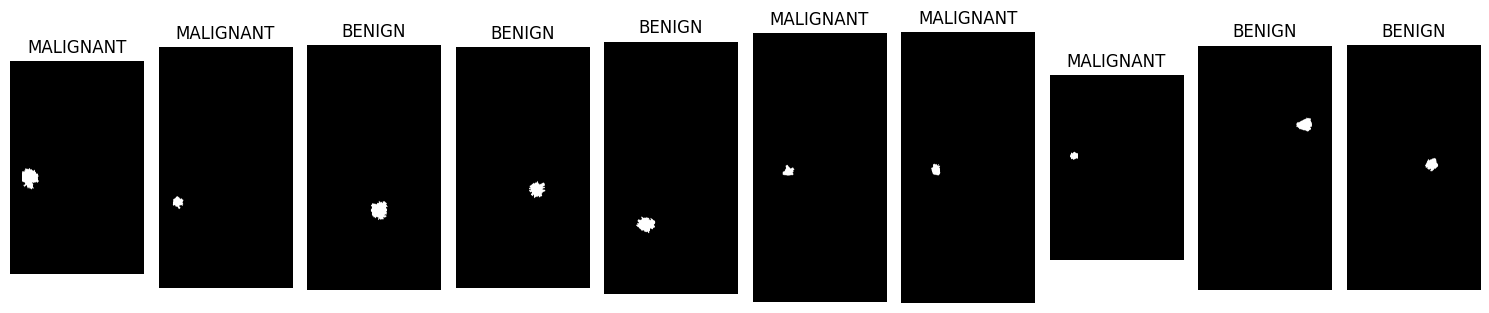

In [ ]:
print('Full Mammograms:\n')
display_images('image_file_path', 10)
#print('Cropped Mammograms:\n')
#display_images('cropped_image_file_path', 5)
#print('Cropped Mammograms:\n')
display_images('ROI_mask_file_path', 10)

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
# Data Preprocessing
def preprocess_image(image_path):
    """Load and resize image to 255x255."""
    image = Image.open(image_path)
    image = image.resize((255, 255))
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

In [ ]:
# Display images function for visualization
def display_images(df, column, number):
    """Displays images in dataset."""
    number_to_visualize = number
    rows = 1
    cols = number_to_visualize
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))

    for index, row in df.head(number_to_visualize).iterrows():
        image_path = row[column]
        image = preprocess_image(image_path)
        ax = axes[index]
        ax.imshow(image, cmap='gray')
        ax.set_title(f"{row['pathology']}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
mass_train['image_array'] = mass_train['image_file_path'].apply(preprocess_image)
mass_train['mask_array'] = mass_train['ROI_mask_file_path'].apply(preprocess_image)
mass_test['image_array'] = mass_test['image_file_path'].apply(preprocess_image)
mass_test['mask_array'] = mass_test['ROI_mask_file_path'].apply(preprocess_image)

In [ ]:
train_full_images = np.array(mass_train['image_array'].tolist())
train_roi_masks = np.array(mass_train['mask_array'].tolist())
test_full_images = np.array(mass_test['image_array'].tolist())
test_roi_masks = np.array(mass_test['mask_array'].tolist())

In [ ]:
def cnn_model(input_size=(255, 255, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    # Decoder with consistent shape handling
    up6 = UpSampling2D(size=(2, 2))(conv5)

    # Use ZeroPadding2D to match dimensions
    up6_padded = ZeroPadding2D(padding=((0, 1), (0, 1)))(up6)
    up6_concat = concatenate([up6_padded, conv4], axis=3)

    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6_concat)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7_padded = ZeroPadding2D(padding=((0, 1), (0, 1)))(up7)
    up7_concat = concatenate([up7_padded, conv3], axis=3)

    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7_concat)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8_padded = ZeroPadding2D(padding=((0, 1), (0, 1)))(up8)
    up8_concat = concatenate([up8_padded, conv2], axis=3)

    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8_concat)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9_padded = ZeroPadding2D(padding=((0, 1), (0, 1)))(up9)
    up9_concat = concatenate([up9_padded, conv1], axis=3)

    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9_concat)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    return model

In [ ]:
import tensorflow as tf

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))  # Cast to float32
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))  # Cast to float32
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)  # Intersection of prediction and ground truth
    dice = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return 1 - dice

In [ ]:
def tversky_loss(y_true, y_pred, alpha=0.7, beta=0.3):
    smooth = 1.0
    y_true_pos = tf.keras.backend.flatten(y_true)
    y_pred_pos = tf.keras.backend.flatten(y_pred)
    true_pos = tf.keras.backend.sum(y_true_pos * y_pred_pos)
    false_neg = tf.keras.backend.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = tf.keras.backend.sum((1 - y_true_pos) * y_pred_pos)
    return 1 - (true_pos + smooth) / (true_pos + alpha * false_neg + beta * false_pos + smooth)

In [ ]:
# Compile and Train the Model
model = cnn_model()

# Use Tversky Loss as the main loss function
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss=lambda y_true, y_pred: tversky_loss(y_true, y_pred),
              metrics=['accuracy', dice_loss])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_full_images, train_roi_masks))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(8).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_full_images, test_roi_masks))
test_dataset = test_dataset.batch(8).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Train the model
#history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=16)

history = model.fit(train_dataset, validation_data=test_dataset, epochs=8, batch_size=16)

Epoch 1/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 124s 497ms/step - accuracy: 0.5558 - dice_loss: 0.9831 - loss: 0.9723 - val_accuracy: 0.9774 - val_dice_loss: 0.9897 - val_loss: 0.9833
Epoch 2/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 31s 186ms/step - accuracy: 0.9191 - dice_loss: 0.9526 - loss: 0.9243 - val_accuracy: 0.9941 - val_dice_loss: 0.9916 - val_loss: 0.9870
Epoch 3/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 189ms/step - accuracy: 0.9743 - dice_loss: 0.8911 - loss: 0.8363 - val_accuracy: 0.9940 - val_dice_loss: 0.9509 - val_loss: 0.9399
Epoch 4/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 42s 193ms/step - accuracy: 0.9849 - dice_loss: 0.8048 - loss: 0.7312 - val_accuracy: 0.9939 - val_dice_loss: 0.8663 - val_loss: 0.8421
Epoch 5/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 197ms/step - accuracy: 0.9894 - dice_loss: 0.7184 - loss: 0.6422 - val_accuracy: 0.9940 - val_dice_loss: 0.7568 - val_loss: 0.7397
Epoch 6/8
165/165 ━━━━━━━━━━━━━━━━━━━━ 41s 196ms/step - accuracy: 0.9914 - dice_loss: 0.6366 - loss: 0.5660 - val_accuracy: 0.994

In [ ]:
model.evaluate(test_full_images, test_roi_masks)

12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9914 - dice_loss: 0.6800 - loss: 0.6546


[0.620583176612854, 0.9919622540473938, 0.6486311554908752]

In [ ]:
predictions = model.predict(test_full_images)

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step


In [ ]:
# Display predictions along with the true masks
def display_predictions(images, true_masks, predicted_masks, indices):
    """Displays the full mammogram, true mask, and predicted mask."""
    n = len(indices)
    fig, axes = plt.subplots(n, 3, figsize=(15, 5 * n))

    for i, index in enumerate(indices):
        image = images[index]
        true_mask = true_masks[index]
        predicted_mask = predicted_masks[i]

        # Display the full mammogram
        axes[i, 0].imshow(image, cmap='gray')
        axes[i, 0].set_title('Full Mammogram')
        axes[i, 0].axis('off')

        # Display the given mask
        axes[i, 1].imshow(true_mask, cmap='gray')
        axes[i, 1].set_title('Given Mask')
        axes[i, 1].axis('off')

        # Display the predicted mask
        axes[i, 2].imshow(predicted_mask, cmap='gray')
        axes[i, 2].set_title('Predicted Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

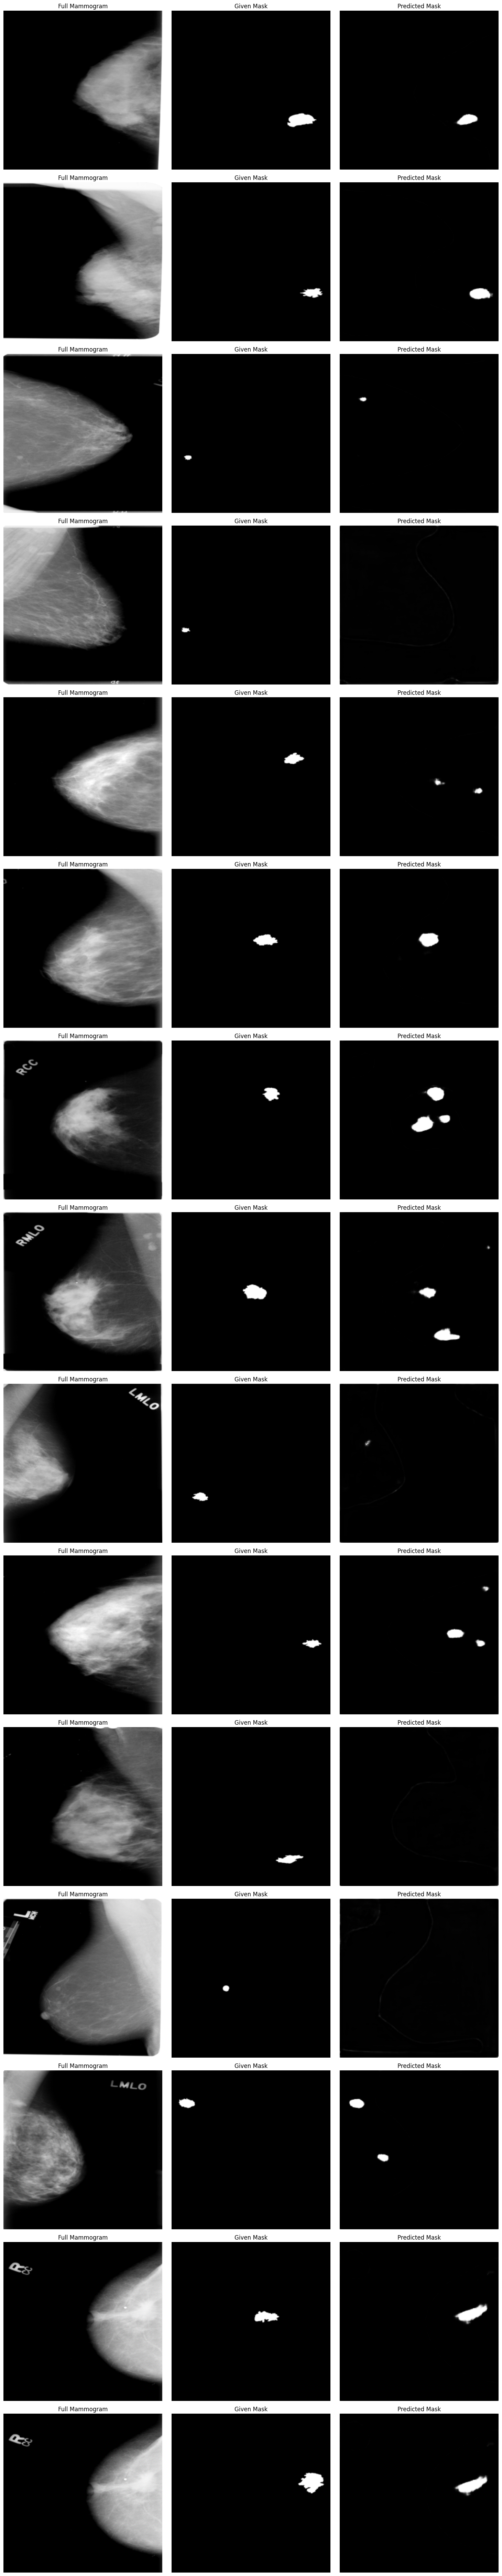

In [ ]:
# Visualize some predictions
indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
display_predictions(test_full_images, test_roi_masks, predictions, indices)

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step


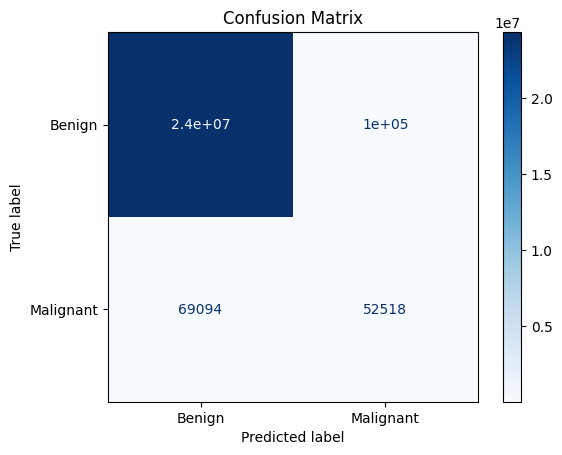

Accuracy: 0.99
Precision: 0.33
Recall: 0.43
F1 Score: 0.38


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

# Function to compute confusion matrix
def calculate_confusion_matrix(true_masks, predicted_masks):
    # Flatten the true masks and predicted masks
    true_masks_flat = true_masks.flatten()
    predicted_masks_flat = predicted_masks.flatten()

    # Compute confusion matrix
    cm = confusion_matrix(true_masks_flat, predicted_masks_flat)
    return cm

# Function to display the confusion matrix
# Function to display the confusion matrix for classification
def display_confusion_matrix(cm, labels=["Benign", "Malignant"]):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


# Function to calculate precision, recall, and F1-score
def calculate_metrics(cm):
    tp = cm[1, 1]  # True positives
    tn = cm[0, 0]  # True negatives
    fp = cm[0, 1]  # False positives
    fn = cm[1, 0]  # False negatives

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1_score

# Get predictions for the test dataset
predictions = model.predict(test_full_images)

# Binarize predictions (assuming output is in range [0, 1] from sigmoid activation)
predictions_binary = (predictions > 0.5).astype(np.uint8)

# Threshold the true masks if they are continuous (e.g., grayscale) to binary
test_roi_masks_binary = (test_roi_masks > 0.5).astype(np.uint8)  # Adjust threshold as necessary

# Calculate confusion matrix
cm = calculate_confusion_matrix(test_roi_masks_binary, predictions_binary)

# Display confusion matrix
display_confusion_matrix(cm)

# Calculate and display precision, recall, and F1-score
accuracy, precision, recall, f1_score = calculate_metrics(cm)
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1_score:.2f}")

In [ ]:
def extract_rois(full_images, predicted_masks):
    """
    Extracts regions of interest (ROIs) from the images based on the predicted masks.

    Args:
        full_images (numpy array): The original full mammograms.
        predicted_masks (numpy array): Binary segmentation masks.

    Returns:
        list of numpy arrays: Cropped ROIs from the original images.
    """
    # Squeeze the mask to remove the last dimension if it exists
    predicted_masks = np.squeeze(predicted_masks, axis=-1)  # Convert (378, 255, 255, 1) to (378, 255, 255)

    rois = []
    for image, mask in zip(full_images, predicted_masks):
        # Ensure the mask is binary and 2D
        mask = (mask > 0).astype(np.uint8)

        # Find bounding box of the segmented region
        coords = np.argwhere(mask > 0)  # Get coordinates of mask
        if coords.size == 0:
            print("No segmented region found for this image.")
            continue
        x_min, y_min = coords.min(axis=0)
        x_max, y_max = coords.max(axis=0)

        # Crop the region of interest
        roi = image[x_min:x_max+1, y_min:y_max+1]
        rois.append(roi)

    return rois


In [ ]:
print(test_full_images.shape)
print(predicted_masks_binary.shape)

(378, 255, 255)
(378, 255, 255, 1)


In [ ]:
# Extract ROIs using the model predictions
predicted_masks_binary = predictions
rois = extract_rois(test_full_images, predicted_masks_binary)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_classification_model(input_size=(128, 128, 1)):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_size),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Output: 0 (benign) or 1 (malignant)
    ])
    return model

classification_model = build_classification_model()
classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Resize ROIs to match input size
roi_images = [cv2.resize(roi, (128, 128)) for roi in rois]  # Adjust size as necessary
roi_images = np.expand_dims(roi_images, axis=-1)  # Add channel dimension

# Labels: Assume `labels` is a list of 0 (benign) and 1 (malignant)
X_train, X_test, y_train, y_test = train_test_split(roi_images, labels, test_size=0.2, random_state=42)

# Data augmentation for training
train_datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.2, horizontal_flip=True)
train_generator = train_datagen.flow(X_train, y_train, batch_size=16)

NameError: name 'labels' is not defined

In [ ]:
# Train the classification model
history = classification_model.fit(train_generator, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model
test_loss, test_accuracy = classification_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

In [ ]:
def predict_malignancy(full_image, segmentation_model, classification_model):
    """
    Predicts whether a mammogram is benign or malignant based on segmentation and classification.

    Args:
        full_image (numpy array): The full mammogram image.
        segmentation_model: Trained segmentation model.
        classification_model: Trained classification model.

    Returns:
        int: 0 (benign) or 1 (malignant).
    """
    # Step 1: Predict mask
    predicted_mask = segmentation_model.predict(np.expand_dims(full_image, axis=0))[0]
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

    # Step 2: Extract ROI
    rois = extract_rois([full_image], [predicted_mask_binary])
    if len(rois) == 0:
        return -1  # No ROI detected; handle appropriately

    # Step 3: Resize ROI to match classification model input size
    roi_resized = cv2.resize(rois[0], (128, 128))
    roi_resized = np.expand_dims(roi_resized, axis=-1)  # Add channel dimension
    roi_resized = np.expand_dims(roi_resized, axis=0)   # Batch dimension

    # Step 4: Predict malignancy
    malignancy_score = classification_model.predict(roi_resized)[0][0]
    return int(malignancy_score > 0.5)  # Return 1 for malignant, 0 for benign

In [ ]:
results = [predict_malignancy(img, model, classification_model) for img in test_full_images]
accuracy = np.mean([1 if pred == true else 0 for pred, true in zip(results, true_labels)])
print(f"End-to-End Test Accuracy: {accuracy:.2f}")